# Dissertation: Community Detection Illustration

In [1]:
import networkx as nx
import networkx.algorithms.community as nx_comm
import random
import itertools

In [30]:
G = nx.gnm_random_graph(30,60)
pos = nx.spring_layout(G, seed=12345)

Partition via Louvain's method is:

{3}
{1, 2, 6, 9, 11, 18, 20, 21, 22, 25}
{17, 10, 5, 26, 28, 13, 14}
{8, 19, 16}
{0, 4, 7, 12, 15, 23, 24, 27, 29}


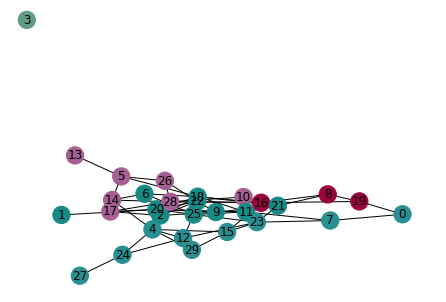

In [31]:
p1 = nx_comm.louvain_communities(G)
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(len(p1))]

color_map = []
for node in G:
    for group_index, group in enumerate(p1):
        if node in group: color_map.append(color[group_index])
print("Partition via Louvain's method is:\n\n" + "\n".join([str(ele) for ele in p1]))
nx.draw(G, node_color=color_map, with_labels=True)

In [32]:
# https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.centrality.girvan_newman.html
def gn_draw(G, communities):
    color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(len(communities))]

    color_map = []
    for node in G:
        for group_index, group in enumerate(communities):
            if node in group: color_map.append(color[group_index])

    print("Partition via girvan_newman's method is:\n\n" + "\n".join([str(ele) for ele in communities]))
    nx.draw(G, node_color=color_map, with_labels=True)
    
comp = nx_comm.girvan_newman(G)

Partition via girvan_newman's method is:

{0, 8, 19}
{1}
{2, 6, 9, 11, 17, 18, 20, 21, 22, 25}
{3}
{4, 12, 24, 27, 29}
{13, 5}
{23, 15, 7}
{10, 14, 16, 26, 28}


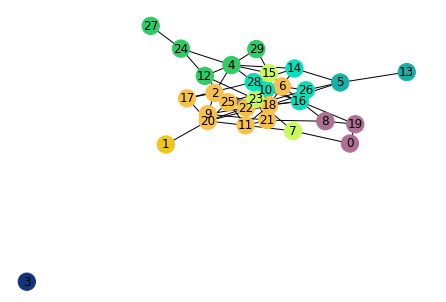

In [33]:
[next(comp) for i in range(5)]
gn_draw(G, next(comp))